In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore")

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_path = "cell_images\\cell_images\\train"
test_path  = "cell_images\\cell_images\\test"

In [4]:
image_shape = (130, 130, 3)

In [5]:
image_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1 ,
                               shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode = 'nearest')

In [6]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [7]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [8]:
train_image_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2], color_mode='rgb', batch_size=32, class_mode='binary')

Found 24958 images belonging to 2 classes.


In [9]:
test_image_gen = image_gen.flow_from_directory(test_path, target_size=image_shape[:2], color_mode='rgb', batch_size=32, class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [10]:
NASNetLarge_model = Sequential()

pretrained_model= tf.keras.applications.NASNetLarge(include_top=False,
                   input_shape=image_shape,
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

NASNetLarge_model.add(pretrained_model)

NASNetLarge_model.add(Flatten())
NASNetLarge_model.add(Dense(128, activation='relu'))
NASNetLarge_model.add(Dense(1, activation='sigmoid'))

343610240/343610240 [==============================] - 39s 0us/step


In [11]:
NASNetLarge_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 4032)              84916818  
                                                                 
 flatten (Flatten)           (None, 4032)              0         
                                                                 
 dense (Dense)               (None, 128)               516224    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 85,433,171
Trainable params: 516,353
Non-trainable params: 84,916,818
_________________________________________________________________


In [12]:
NASNetLarge_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [14]:
NASNetLarge_model.fit(train_image_gen, epochs=50, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/50
780/780 [==============================] - 240s 272ms/step - loss: 1.8737 - accuracy: 0.5689 - val_loss: 0.8675 - val_accuracy: 0.6227
Epoch 2/50
780/780 [==============================] - 124s 159ms/step - loss: 1.0017 - accuracy: 0.6005 - val_loss: 0.6716 - val_accuracy: 0.6565
Epoch 3/50
780/780 [==============================] - 105s 135ms/step - loss: 0.7160 - accuracy: 0.6254 - val_loss: 0.6370 - val_accuracy: 0.6496
Epoch 4/50
780/780 [==============================] - 106s 136ms/step - loss: 0.6615 - accuracy: 0.6338 - val_loss: 0.6343 - val_accuracy: 0.6569
Epoch 5/50
780/780 [==============================] - 113s 145ms/step - loss: 0.6278 - accuracy: 0.6531 - val_loss: 0.6066 - val_accuracy: 0.6727
Epoch 6/50
780/780 [==============================] - 122s 157ms/step - loss: 0.6211 - accuracy: 0.6591 - val_loss: 0.6335 - val_accuracy: 0.6373
Epoch 7/50
780/780 [==============================] - 118s 151ms/step - loss: 0.6266 - accuracy: 0.6475 - val_loss: 0.6307 -

In [15]:
history = pd.DataFrame(NASNetLarge_model.history.history)

In [16]:
history.head()

,loss,accuracy,val_loss,val_accuracy
0,1.873709,0.568876,0.867537,0.622692
1,1.001745,0.600489,0.671584,0.656538
2,0.715985,0.625371,0.636959,0.649615
3,0.661472,0.633825,0.634263,0.656923
4,0.627841,0.653057,0.606615,0.672692


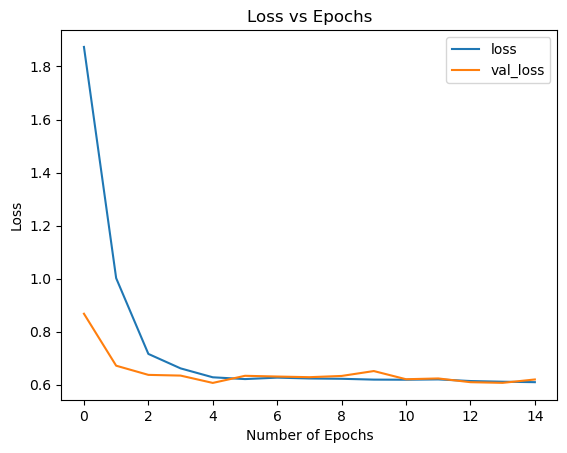

In [17]:
history[["loss", "val_loss"]].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.savefig('LossVsEpochsNNL.png')
plt.show()

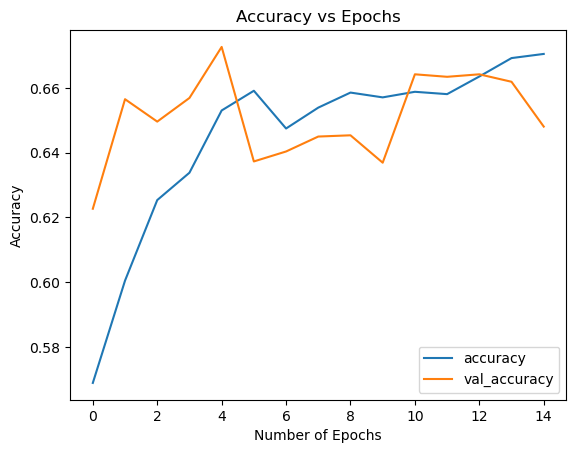

In [18]:
history[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.savefig('AccuracyvsEpochsNNL.png')
plt.show()

In [19]:
predictions = NASNetLarge_model.predict(test_image_gen)

82/82 [==============================] - 16s 131ms/step


In [20]:
predictions = predictions >= 0.5

In [21]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.75      0.50      0.60      1300
           1       0.62      0.83      0.71      1300

    accuracy                           0.67      2600
   macro avg       0.69      0.67      0.66      2600
weighted avg       0.69      0.67      0.66      2600



In [22]:
confusion_matrix(test_image_gen.classes, predictions)

array([[ 648,  652],
       [ 219, 1081]], dtype=int64)

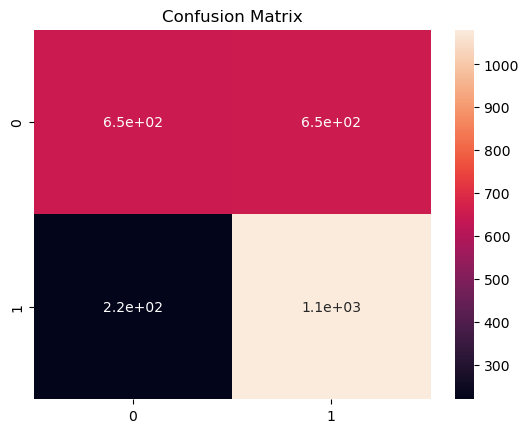

In [23]:
import seaborn as sns
DetaFrame_cm = pd.DataFrame(confusion_matrix(test_image_gen.classes, predictions), range(2), range(2))
sns.heatmap(DetaFrame_cm, annot=True)
plt.title("Confusion Matrix")
plt.savefig('ConfusionMatrixHeatmapNNL.png')
plt.show()

In [24]:
NASNetLarge_model.save("MalariaPredictionsNNL.h5")